Found beam width before the lens: Width x = 4.241 mm, Width y = 3.84 mm
q3 (after second lens): (-1500.000000378498+1209634.7045884384j)
q4 (before third lens at z = 441 mm): (-1359.000000378498+1209634.7045884384j)
q5 (after third lens): (-25.399999389592338+0.0005333504011619206j)
z = 20 mm, Width_x = 2.599 mm, Width_y = 2.404 mm
z = 30 mm, Width_x = 1.773 mm, Width_y = 1.558 mm
z = 40 mm, Width_x = 0.934 mm, Width_y = 0.799 mm
z = 50 mm, Width_x = 0.106 mm, Width_y = 0.096 mm
z = 60 mm, Width_x = 0.830 mm, Width_y = 0.777 mm
z = 70 mm, Width_x = 1.483 mm, Width_y = 1.384 mm
z = 80 mm, Width_x = 2.106 mm, Width_y = 1.982 mm
z = 90 mm, Width_x = 2.945 mm, Width_y = 2.818 mm
z = 100 mm, Width_x = 3.907 mm, Width_y = 3.704 mm
z = 110 mm, Width_x = 4.456 mm, Width_y = 4.245 mm
z = 120 mm, Width_x = 5.235 mm, Width_y = 4.883 mm
z = 130 mm, Width_x = 6.117 mm, Width_y = 5.763 mm
z = 140 mm, Width_x = 6.814 mm, Width_y = 6.386 mm
z = 467 mm, Width_x = 5.862 mm, Width_y = 5.631 mm
z = 470 mm

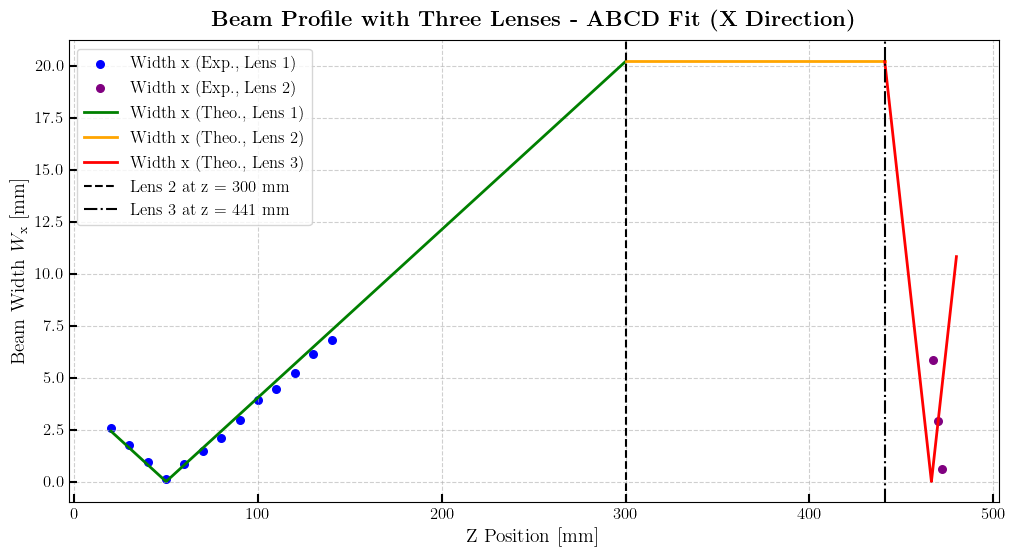

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/fig/beam_profile_ABCD_y_three_lenses.png


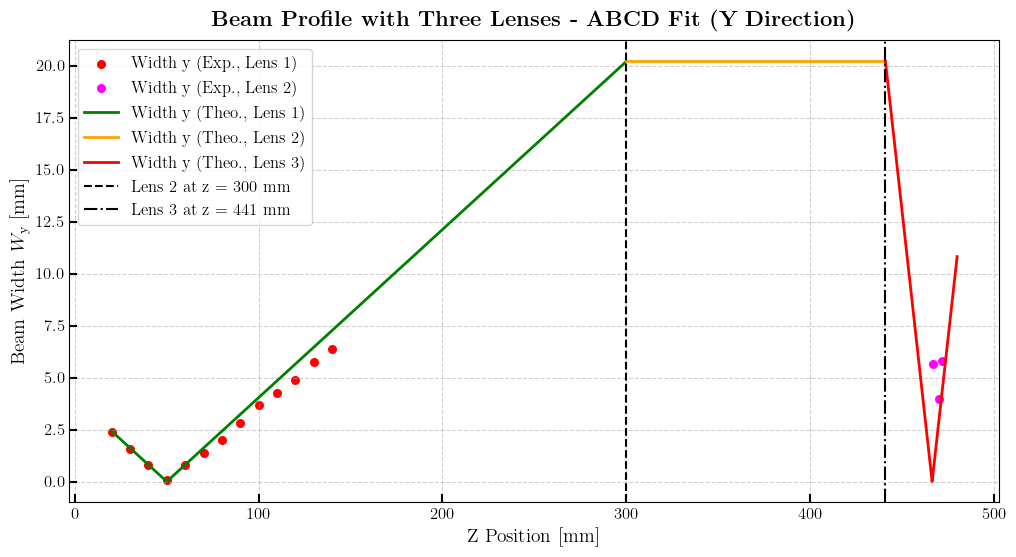

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/" 
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
file_list_2 = sorted(glob.glob(os.path.join(data_path_2, "*mm Beam Results.csv")))
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Process first lens data (up to z = 150 mm)
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 149:  
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

# Process third lens data (z >= 441 mm) w/ error handling
for file in file_list_2:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0]) 
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    wx, wy = None, None
    for line in lines:
        if "Width x" in line:
            value = line.split()[2]
            try:
                wx = float(value)
            except ValueError:
                wx = None
        if "Width y" in line:
            value = line.split()[2]
            try:
                wy = float(value)
            except ValueError:
                wy = None
    
    if wx is not None and wy is not None:
        width_x.append(wx)
        width_y.append(wy)
    else:
        print(f"Warning: Skipping file {filename} due to invalid width values")
        z_values.pop()

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50 
focal_length2 = 250  
focal_length3 = 25.4 
wavelength = 1.060e-3  
z_lens2 = 300  
z_lens3 = 441 

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam width before the lens: Width x = {width_x_initial} mm, Width y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

# Read W0_initial from file 
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0 (from second code)
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1)  # Beam parameter just after the first lens

# Propagate to second lens position 
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
print(f"q3 (after second lens): {q3}")

# Propagate to third lens position 
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
print(f"q4 (before third lens at z = {z_lens3} mm): {q4}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
print(f"q5 (after third lens): {q5}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)
z_theoretical3 = np.linspace(z_lens3, 480, 600)  # Propagate forward to z = 480 mm
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Width_x = {wx:.3f} mm, Width_y = {wy:.3f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Data before second lens
mask1 = z_values < 300
plt.scatter(z_values[mask1], width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Data after second lens
mask2 = z_values >= z_lens2
plt.scatter(z_values[mask2], width_x[mask2], color='purple', label='Width x (Exp., Lens 2)', marker='o', s=30) #offset of -5mm in z_values here
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width x (Theo., Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width x (Theo., Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width x (Theo., Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
plt.scatter(z_values[mask1], width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Data after third lens
plt.scatter(z_values[mask2], width_y[mask2], color='magenta', label='Width y (Exp., Lens 2)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width y (Theo., Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width y (Theo., Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width y (Theo., Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

### ZOOM ON THIRD LENS

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/fig/beam_profile_theoretical_x_third_lens.png


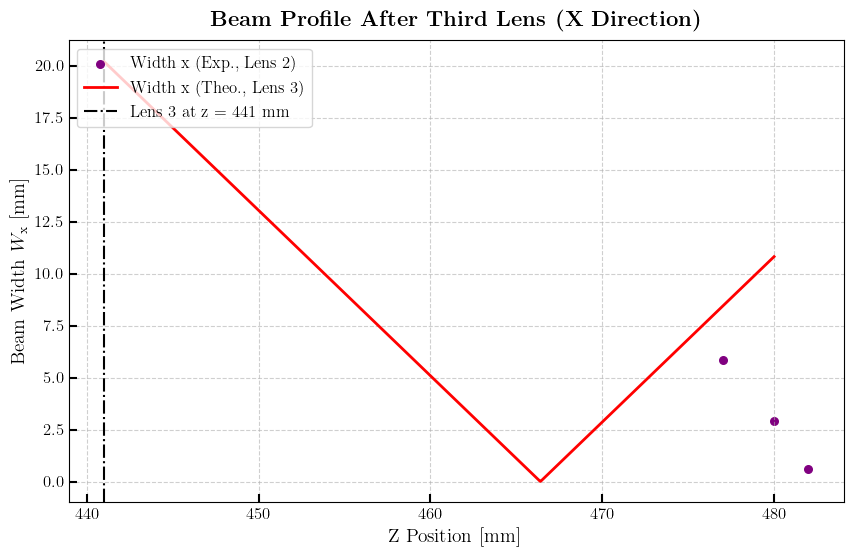

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/fig/beam_profile_theoretical_y_third_lens.png


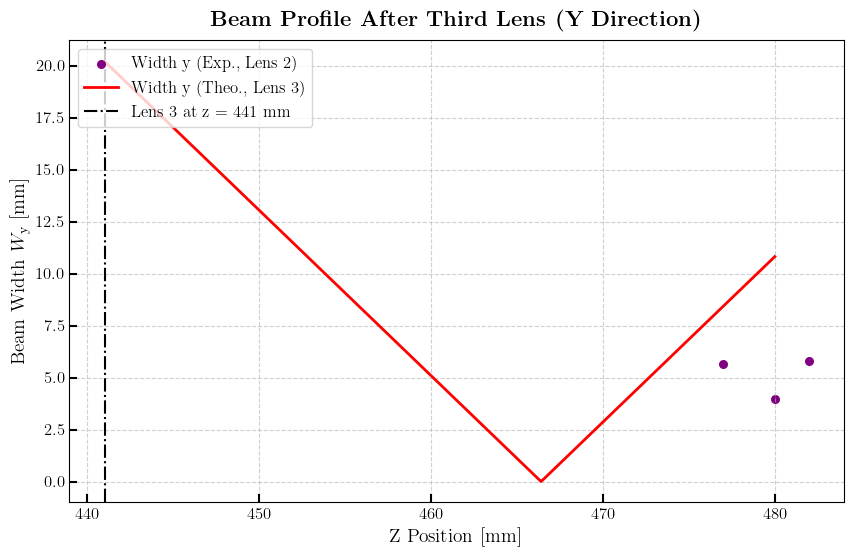

In [4]:
# Width after the third lens (z >= 441 mm)
plt.figure(figsize=(10, 6))
mask2 = z_values >= z_lens2
plt.scatter(z_values[mask2]+10, width_x[mask2], color='purple', label='Width x (Exp., Lens 2)', marker='o', s=30)
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width x (Theo., Lens 3)')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile After Third Lens (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_third_lens = os.path.join(fig_dir, "beam_profile_theoretical_x_third_lens.png")
plt.savefig(save_third_lens, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_third_lens}")
plt.show()

plt.figure(figsize=(10, 6))
mask2 = z_values >= z_lens2
plt.scatter(z_values[mask2]+10, width_y[mask2], color='purple', label='Width y (Exp., Lens 2)', marker='o', s=30)
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width y (Theo., Lens 3)')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile After Third Lens (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_third_lens = os.path.join(fig_dir, "beam_profile_theoretical_y_third_lens.png")
plt.savefig(save_third_lens, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_third_lens}")
plt.show()



### SECOND LENS: ATTEMPT AT CHARACTERIZATION

Found beam width before the lens: Width x = 4.241 mm, Width y = 3.84 mm
q3 (after second lens): (166.66676554191514+0.14352351834526722j)
q4 (before third lens at z = 441 mm): (457.66676554191514+0.14352351834526722j)
q5 (after third lens): (-26.892504120848216+0.0004955491831540648j)
z = 20 mm, Width_x = 2.599 mm, Width_y = 2.404 mm
z = 30 mm, Width_x = 1.773 mm, Width_y = 1.558 mm
z = 40 mm, Width_x = 0.934 mm, Width_y = 0.799 mm
z = 50 mm, Width_x = 0.106 mm, Width_y = 0.096 mm
z = 60 mm, Width_x = 0.830 mm, Width_y = 0.777 mm
z = 70 mm, Width_x = 1.483 mm, Width_y = 1.384 mm
z = 80 mm, Width_x = 2.106 mm, Width_y = 1.982 mm
z = 90 mm, Width_x = 2.945 mm, Width_y = 2.818 mm
z = 100 mm, Width_x = 3.907 mm, Width_y = 3.704 mm
z = 110 mm, Width_x = 4.456 mm, Width_y = 4.245 mm
z = 120 mm, Width_x = 5.235 mm, Width_y = 4.883 mm
z = 130 mm, Width_x = 6.117 mm, Width_y = 5.763 mm
z = 140 mm, Width_x = 6.814 mm, Width_y = 6.386 mm
z = 170 mm, Width_x = 9.225 mm, Width_y = 9.862 mm
z = 180 

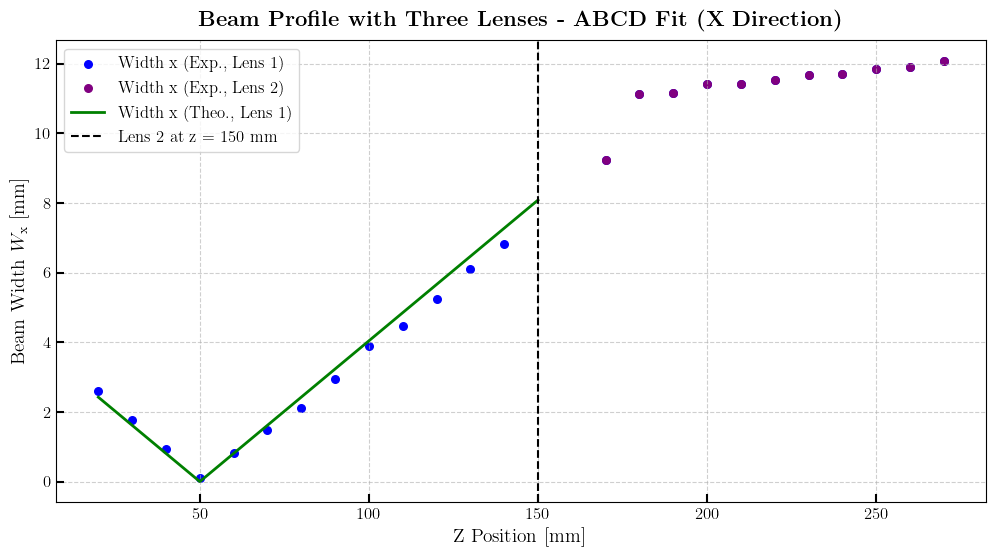

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250401/fig/beam_profile_ABCD_y_three_lenses.png


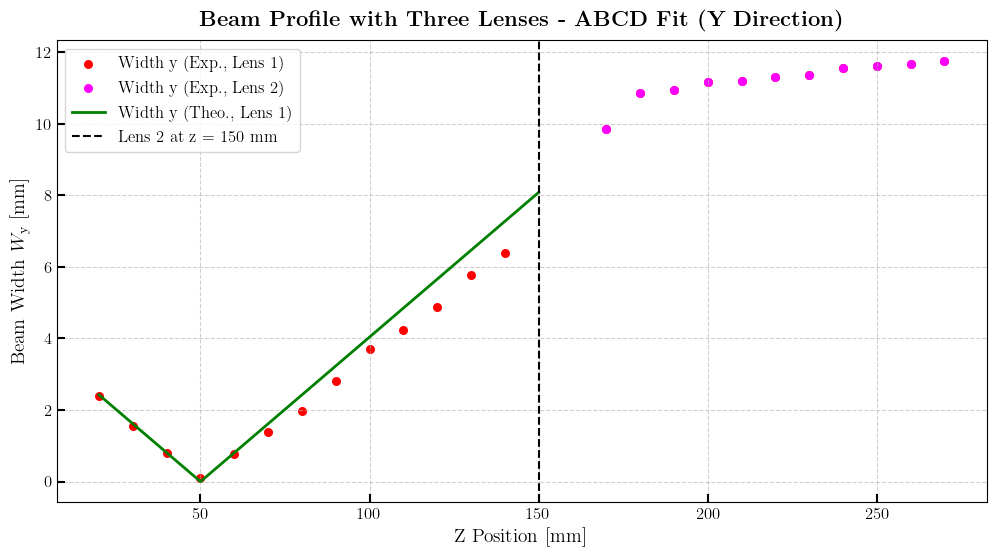

In [21]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250401/"
#data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250404/third_lens"
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
file_list_2 = sorted(glob.glob(os.path.join(data_path_2, "*mm Beam Results.csv")))
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Process first lens data (only up to z = 150 mm)
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 149:  # Only include data up to z = 150 mm
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

# Process third lens data (z >= 150 mm) with error handling
for file in file_list_2:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0]) 
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    wx, wy = None, None
    for line in lines:
        if "Width x" in line:
            value = line.split()[2]
            try:
                wx = float(value)
            except ValueError:
                wx = None
        if "Width y" in line:
            value = line.split()[2]
            try:
                wy = float(value)
            except ValueError:
                wy = None
    
    if wx is not None and wy is not None:
        width_x.append(wx)
        width_y.append(wy)
    else:
        print(f"Warning: Skipping file {filename} due to invalid width values")
        z_values.pop()

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50  # First lens focal length in mm
focal_length2 = 250  # Second lens focal length in mm (changed to collimate the beam)
#focal_length3 = 25.4  # Third lens focal length in mm
wavelength = 1.060e-3  # in mm 
z_lens2 = 150  # Position of second lens in mm
#z_lens3 = 441  # Position of third lens in mm

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam width before the lens: Width x = {width_x_initial} mm, Width y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

# Read W0_initial from file 
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0 (from second code)
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1)  # Beam parameter just after the first lens

# Propagate to second lens position (z = 300 mm)
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
print(f"q3 (after second lens): {q3}")

# Propagate to third lens position (z = 441 mm)
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
print(f"q4 (before third lens at z = {z_lens3} mm): {q4}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
print(f"q5 (after third lens): {q5}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)
z_theoretical3 = np.linspace(z_lens3, 480, 600)  # Propagate forward to z = 480 mm
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Width_x = {wx:.3f} mm, Width_y = {wy:.3f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Data before second lens
mask1 = z_values < 300
plt.scatter(z_values[mask1], width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Data after second lens
mask2 = z_values >= z_lens2
plt.scatter(z_values[mask2], width_x[mask2], color='purple', label='Width x (Exp., Lens 2)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width x (Theo., Lens 1)')
#plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width x (Theo., Lens 2)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
plt.scatter(z_values[mask1], width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Data after third lens
plt.scatter(z_values[mask2], width_y[mask2], color='magenta', label='Width y (Exp., Lens 2)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width y (Theo., Lens 1)')
#plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width y (Theo., Lens 2)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

### ALTERNATIVE METHOD

Found beam width before the lens: Width x = 4.241 mm, Width y = 3.84 mm
Fitted beam waist after first lens: W0 = 0.004 mm at z0 = 51.902 mm, z_R = 0.056 mm
q3 (after second lens): (32584.097080786498+958.152758694024j)
q4 (before third lens at z = 441 mm): (32725.097080786498+958.152758694024j)
q5 (after third lens): (-25.419712921207807+0.0005776197189385559j)
z = 20 mm, Width_x = 2.599 mm, Width_y = 2.404 mm
z = 30 mm, Width_x = 1.773 mm, Width_y = 1.558 mm
z = 40 mm, Width_x = 0.934 mm, Width_y = 0.799 mm
z = 50 mm, Width_x = 0.106 mm, Width_y = 0.096 mm
z = 60 mm, Width_x = 0.830 mm, Width_y = 0.777 mm
z = 70 mm, Width_x = 1.483 mm, Width_y = 1.384 mm
z = 80 mm, Width_x = 2.106 mm, Width_y = 1.982 mm
z = 90 mm, Width_x = 2.945 mm, Width_y = 2.818 mm
z = 100 mm, Width_x = 3.907 mm, Width_y = 3.704 mm
z = 110 mm, Width_x = 4.456 mm, Width_y = 4.245 mm
z = 120 mm, Width_x = 5.235 mm, Width_y = 4.883 mm
z = 130 mm, Width_x = 6.117 mm, Width_y = 5.763 mm
z = 140 mm, Width_x = 6.814 mm, 

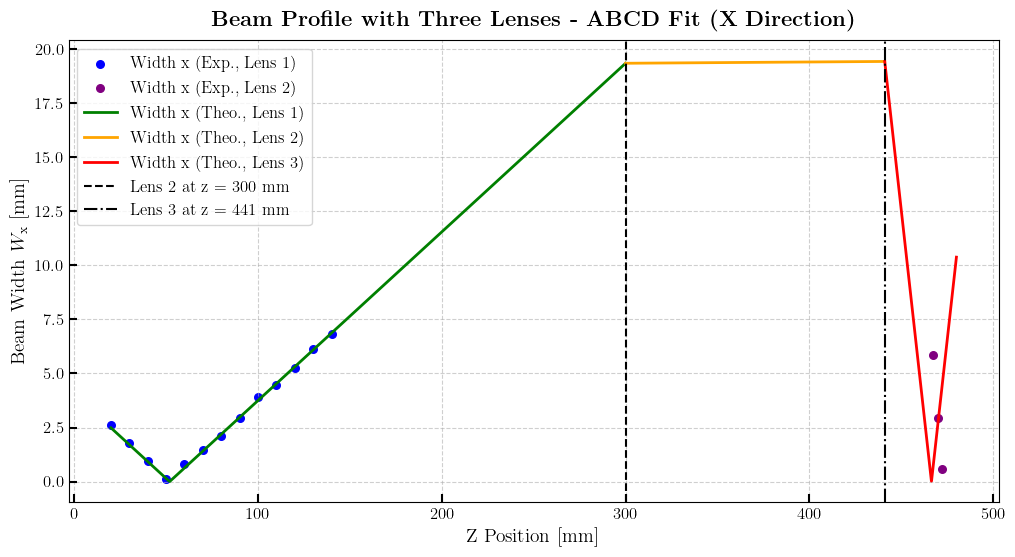

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/fig/beam_profile_ABCD_y_three_lenses.png


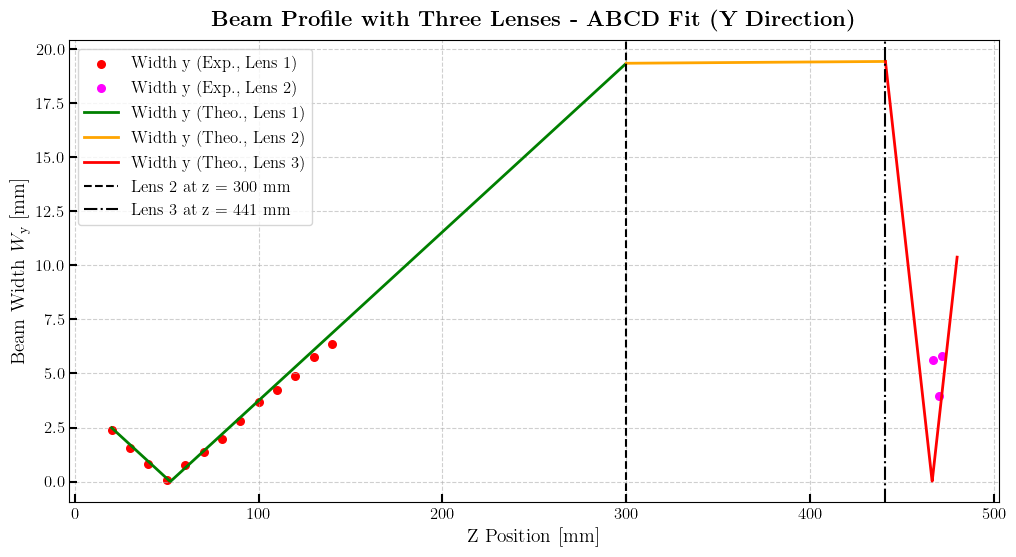

In [22]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/"
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
file_list_2 = sorted(glob.glob(os.path.join(data_path_2, "*mm Beam Results.csv")))
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Process first lens data (up to z = 150 mm)
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 149:  
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

# Process third lens data (z >= 441 mm) w/ error handling
for file in file_list_2:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0]) 
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    wx, wy = None, None
    for line in lines:
        if "Width x" in line:
            value = line.split()[2]
            try:
                wx = float(value)
            except ValueError:
                wx = None
        if "Width y" in line:
            value = line.split()[2]
            try:
                wy = float(value)
            except ValueError:
                wy = None
    
    if wx is not None and wy is not None:
        width_x.append(wx)
        width_y.append(wy)
    else:
        print(f"Warning: Skipping file {filename} due to invalid width values")
        z_values.pop()

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50 
focal_length2 = 250  
focal_length3 = 25.4 
wavelength = 1.060e-3  
z_lens2 = 300  
z_lens3 = 441 

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam width before the lens: Width x = {width_x_initial} mm, Width y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Fit initial beam parameter q0 using data after the first lens 
def beam_width(z, W0, z0):
    z_R = np.pi * W0**2 / wavelength
    return W0 * np.sqrt(1 + ((z - z0) / z_R)**2)

# Use data from z = 20 to 150 mm to fit the beam parameter after the first lens
mask_fit = (z_values >= 20) & (z_values <= 150)
z_fit = z_values[mask_fit]
width_x_fit = width_x[mask_fit]

# Initial guess: W0 from the minimum width after the first lens, z0 at the focal length
W0_guess = width_x.min()  # Minimum width after the first lens
z0_guess = focal_length1  # Assume waist is near the focal length of the first lens
popt, pcov = curve_fit(beam_width, z_fit, width_x_fit, p0=[W0_guess, z0_guess])
W0_fitted, z0_fitted = popt
z_R_fitted = np.pi * W0_fitted**2 / wavelength
print(f"Fitted beam waist after first lens: W0 = {W0_fitted:.3f} mm at z0 = {z0_fitted:.3f} mm, z_R = {z_R_fitted:.3f} mm")

# Calculate q at z = 0 (just after the first lens) based on the fitted waist
q1 = (0 - z0_fitted) + 1j * z_R_fitted  # q at z = 0 after the first lens

# Propagate to second lens position (z = 300 mm)
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
print(f"q3 (after second lens): {q3}")

# Propagate to third lens position (z = 441 mm)
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
print(f"q4 (before third lens at z = {z_lens3} mm): {q4}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
print(f"q5 (after third lens): {q5}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)
z_theoretical3 = np.linspace(z_lens3, 480, 600)  # Propagate forward to z = 480 mm
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Width_x = {wx:.3f} mm, Width_y = {wy:.3f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Data before second lens
mask1 = z_values < 300
plt.scatter(z_values[mask1], width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Data after second lens
mask2 = z_values >= z_lens2
plt.scatter(z_values[mask2], width_x[mask2], color='purple', label='Width x (Exp., Lens 2)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width x (Theo., Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width x (Theo., Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width x (Theo., Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
plt.scatter(z_values[mask1], width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Data after third lens
plt.scatter(z_values[mask2], width_y[mask2], color='magenta', label='Width y (Exp., Lens 2)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width y (Theo., Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width y (Theo., Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width y (Theo., Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()